# COOKIE: Community Observation On cooKie dIstribution on the intErnet

![alternative text](cookies.png)

In [42]:
#imports

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
pd.options.mode.chained_assignment = None  # default='warn'

In [43]:
# data 
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = path + "/data/companies_cookie_data.csv"
df = pd.read_csv(data_path, sep=";")

### Relevant columns in the dataset

**site_visit_url:** websites the bot has visited

**crawl:** This database only has non - disinformation websites (pilot_1_US_base) and disinformation websites (pilot_1_US_misinfo)

**is_third_party:** cookie set by the domain visited (first-party) set by another domain = third_party (third-party)

**ps_plus_1:** domain of the third-party website

**disconnect_tracker_category:** if the third-party is associated with some type of content/function (Advertisement, Social,Fingerprinting...) that information is in this column. If none NaN

**companies:** Big company behind the third-party

## Data Cleaning

In [44]:
df = df.loc[df['is_third_party'] == 'third_party']

# assign a unique ID to the websites and the third-party companies
df["url_id"] = LabelEncoder().fit_transform(df["site_visit_url"])
df["tp_id"] = LabelEncoder().fit_transform(df["ps_plus_1"])

In [45]:
# store the mappings into dictionaries 
mapping_sites = dict(zip(df.url_id, df.site_visit_url))     # url_id -> url
mapping_crawl = dict(zip(df.url_id, df.crawl))              # url_id -> crawl (misinfo or not)
mapping_tp = dict(zip(df.tp_id, df.ps_plus_1))              # third-party id -> domain
mapping_companies = dict(zip(df.tp_id, df.companies))       # third-party id -> main company

In [46]:
# maybe not necessay, but convert the IDs into strings
df['url_id'] = df['url_id'].apply(lambda x : str(x))
df['tp_id'] = df['tp_id'].apply(lambda x : str(x))

In [47]:
# create a new column called 'texts' where we flatten all the third-party companies acting on each website
df['texts'] = df.groupby(['site_visit_url'])['ps_plus_1'].transform(lambda x: ' '.join(x))

# drop duplicated columns
df = df.drop_duplicates(subset='site_visit_url')

# edgelist
df[['site_visit_url', 'texts']].head(10)

site_visit_url  \
2        http://www.bavnews.am   
14         http://www.polic.am   
17       http://www.doctors.am   
35      http://www.starnews.am   
65       http://www.armsoft.am   
93   http://www.caspianagro.az   
97         http://www.fikir.az   
122   http://www.italdizain.az   
141         http://www.blog.ba   
247      http://www.judson.biz   

                                                 texts  
2    doubleclick.net yandex.ru yandex.ru yandex.ru ...  
14                                          google.com  
17                     doubleclick.net doubleclick.net  
35   adriver.ru adriver.ru adriver.ru adriver.ru ad...  
65   facebook.com prfct.co prfct.co prfct.co prfct....  
93                             youtube.com youtube.com  
97   clarity.ms clarity.ms yadro.ru yandex.ru yande...  
122                bitrix.info bitrix.info bitrix.info  
141  quantserve.com quantserve.com quantserve.com q...  
247                                  bing.com bing.com

In [48]:
# nodes on the left
titles = df['site_visit_url'].tolist()
titles = [h.split()[0] for h in titles]

# nodes on the right
corpus = df['texts'].tolist()
texts = [h.split() for h in corpus]



## TopSBM: Topic Modeling with Stochastic Block Models

In [49]:
from sbmtm import sbmtm
import graph_tool.all as gt

In [50]:
# fit data
model = sbmtm()

## word-document network from the corpus
model.make_graph(texts,documents=titles)

## fit the model
gt.seed_rng(32) ## seed for graph-tool's random number generator --> same results
model.fit()

<NestedBlockState object, with base <BlockState object with 2560 blocks (391 nonempty), degree-corrected, for graph <Graph object, undirected, with 2560 vertices and 7260 edges, 2 internal vertex properties, 1 internal edge property, at 0x165595e50>, at 0x158e35dd0>, and 7 levels of sizes [(2560, 391), (391, 113), (113, 49), (49, 16), (16, 4), (4, 2), (2, 1)] at 0x158e39d50>


In [51]:
# assign colors to nodes based on their attributes

colors = {
    'pilot_1_US_base': '#50A2A7',
    'pilot_1_US_misinfo': '#9B2915',
    'Google': '#E9B44C',
    'Yandex': '#5762D5',
    'AddThis': '#AA9ABA'
}

big_companies = ['Google', 'Yandex', 'AddThis', 'Facebook', 'WPP', 'PubMatic',
       'Rocket Fuel', 'Microsoft', 'SMI2', 'comScore', 'Yahoo!']

vertex_colors = [colors[c] for c in mapping_crawl.values()] + [colors[c] if c in colors.keys() else 'white' for c in mapping_companies.values()]

In [52]:
# assign node attributes to the graph

# vertex name
vertex_text = model.g.vp.name.get_2d_array([0])[0]
model.state.g.vp['vertex_text'] = model.state.g.new_vp('string', vals = vertex_text)

# vertex color and size
model.state.g.vp['vertex_color'] = model.state.g.new_vp('string', vals = vertex_colors)
model.state.g.vp['vertex_size'] = model.state.g.new_vp('int', val = 5)


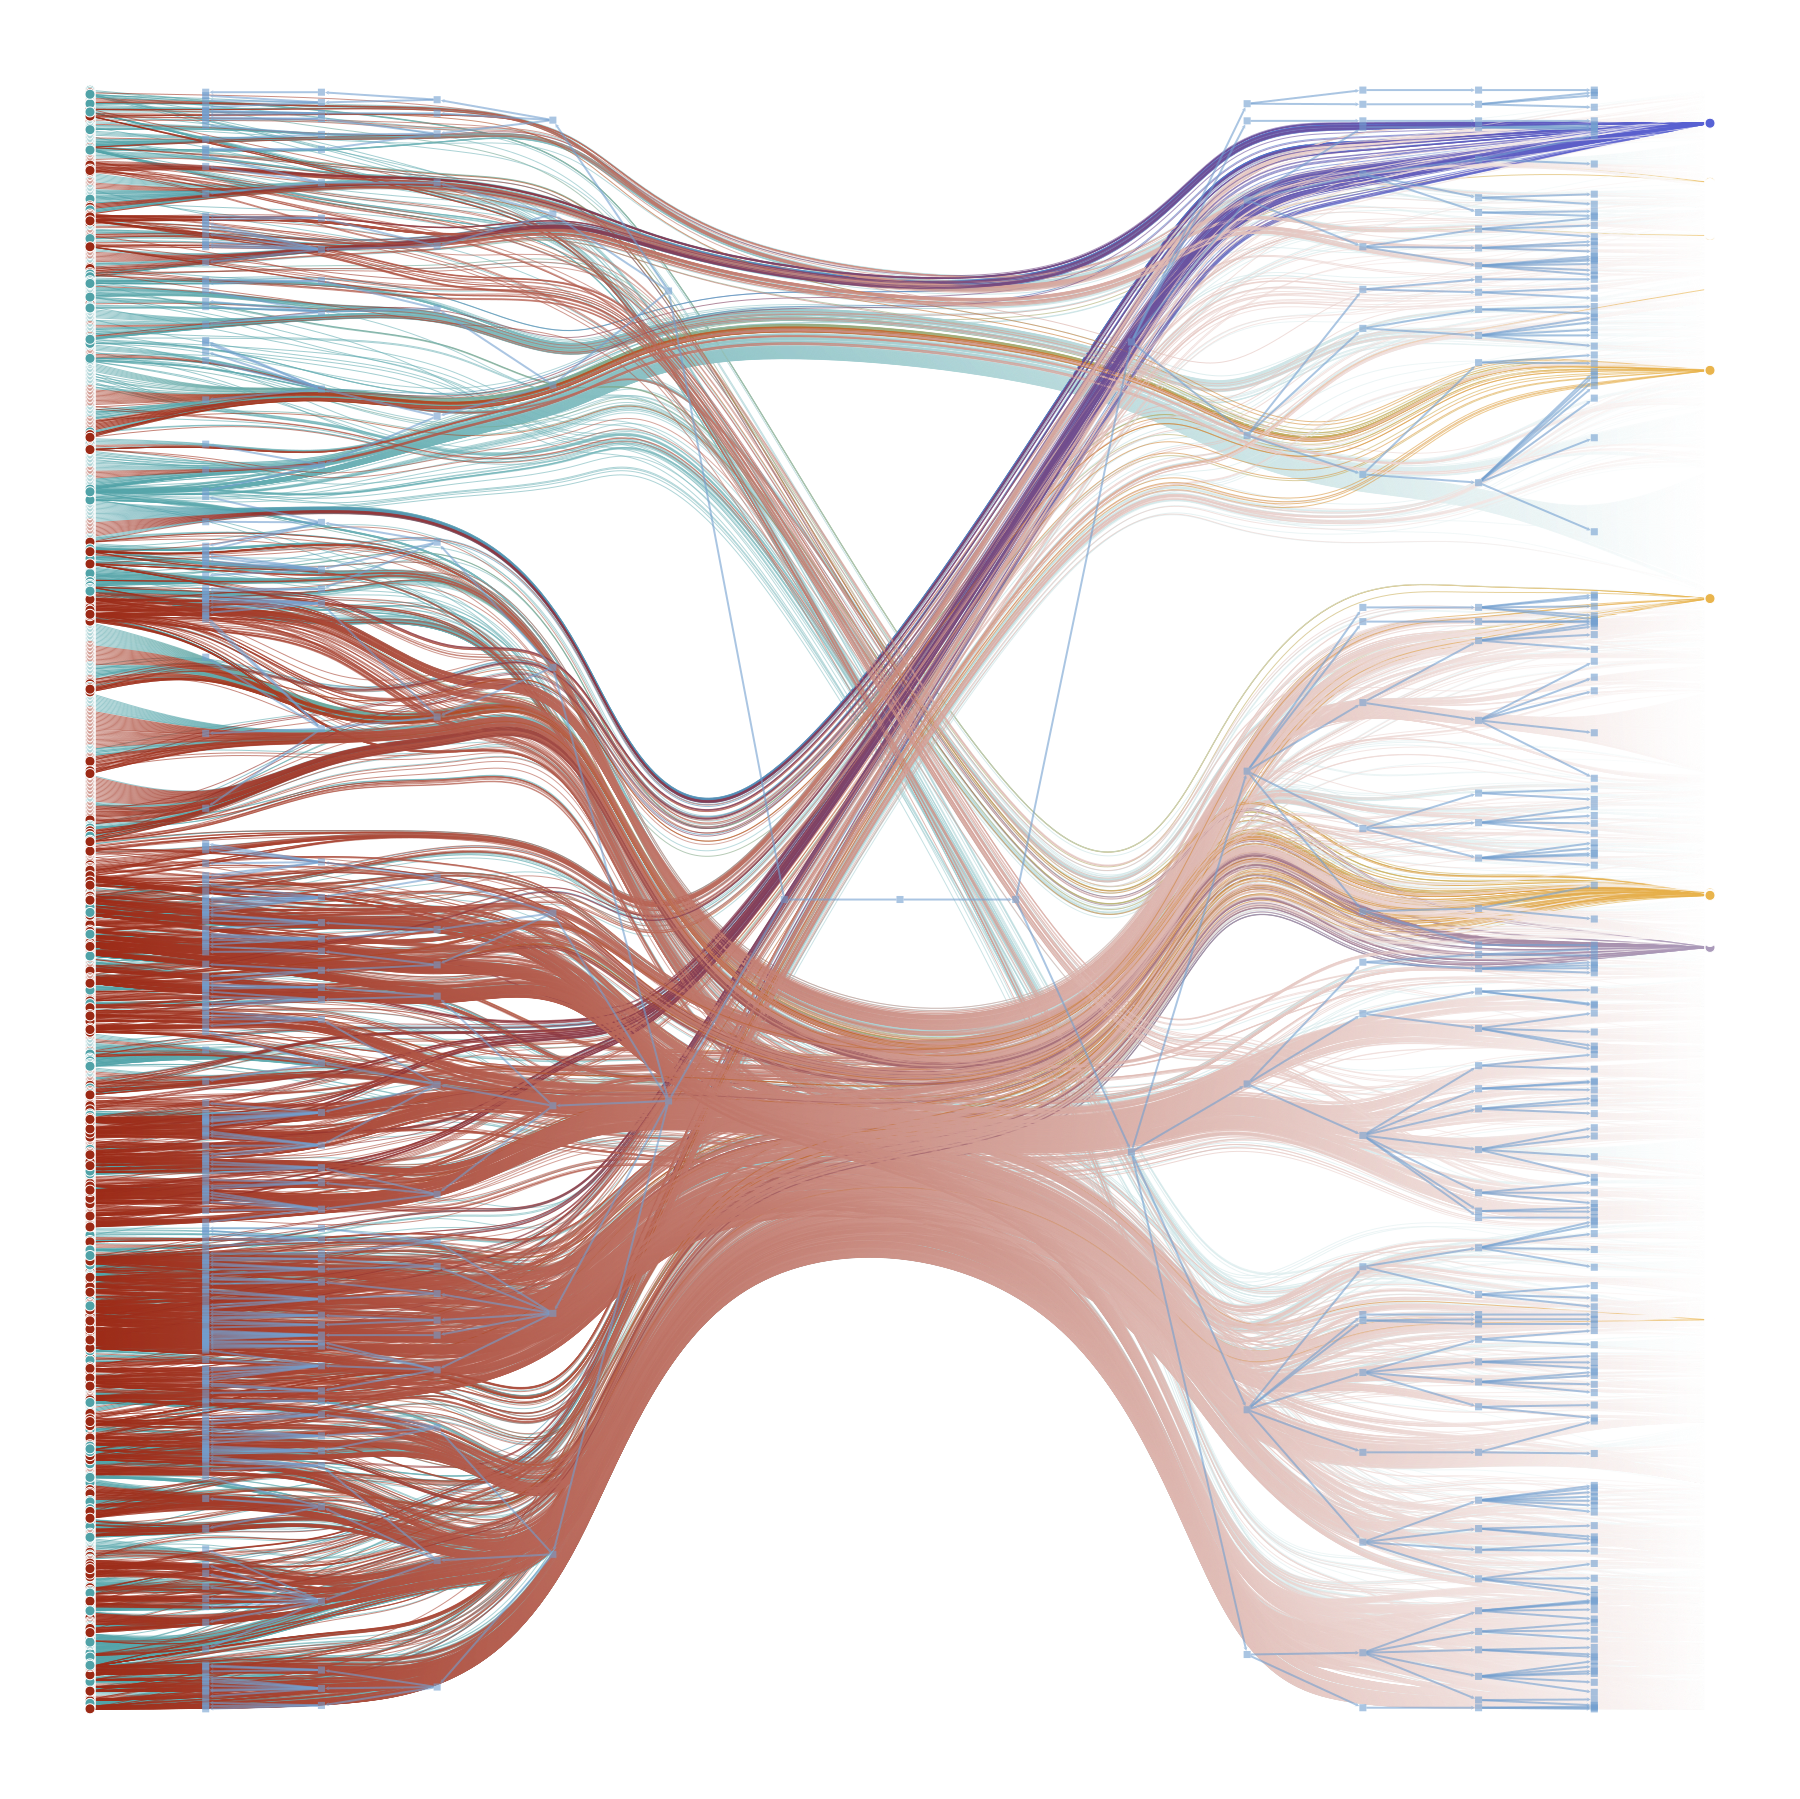

In [56]:
# plot

model.plot(nedges=10000, 
           vertex_size = model.g.vp.vertex_size,
           vertex_fill_color = model.g.vp.vertex_color,
           vertex_color = 'white',          
           bg_color ='white',
           output_size = (900,200))


plt.show()